<a href="https://colab.research.google.com/github/rudraxx/pytorch/blob/main/05_fashion_mnist_CNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt


In [2]:
# Load Fashion MNIST data
# Split into train/val set

#Create the dataloaders to get batched data

# Create CNN architecture

# Train model. Run validation per epoch
#Plot the loss


In [43]:
#Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device} device selected")

cpu device selected


In [40]:
#Set the Hyperparameters
BATCH_SIZE = 128
EPOCHS=20
LR = 1e-3



In [4]:
#Load the datasets
transform = transforms.Compose([
    transforms.ToTensor(),
])

#Train dataset
fashion_ds_train = datasets.FashionMNIST(root="root",
                                 train=True,
                                 download=True,
                                 transform=transform)

ds_test = datasets.FashionMNIST(root="root",
                                train=False,
                                 download=True,
                                transform=transform)

print(fashion_ds_train)

100%|██████████| 26421880/26421880 [00:01<00:00, 16813676.56it/s]


Extracting root/FashionMNIST/raw/train-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275839.60it/s]


Extracting root/FashionMNIST/raw/train-labels-idx1-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5067702.77it/s]


Extracting root/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to root/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6392029.90it/s]

Extracting root/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to root/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: root
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [12]:
#Get the labels for this dataset
labels_dict = {k:v for k,v in enumerate(fashion_ds_train.classes)}
print(labels_dict)


{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
T-shirt/top


In [5]:
#Split into train and validation
ds_train, ds_val = torch.utils.data.random_split(fashion_ds_train,[0.8, 0.2])

#Print the size
print(f"ds_train size = ", {len(ds_train)})
print(f"ds_val size = ", {len(ds_val)})
print(f"ds_test size = ", {len(ds_test)})


ds_train size =  {48000}
ds_val size =  {12000}
ds_test size =  {10000}


In [38]:
# Create the data loader
dl_train = DataLoader(ds_train,
                      batch_size=BATCH_SIZE,
                      shuffle=True)

dl_val  = DataLoader(ds_val,
                      batch_size=BATCH_SIZE,
                      shuffle=False)

dl_test = DataLoader(ds_test,
                      batch_size=BATCH_SIZE,
                      shuffle=False)



torch.Size([128, 1, 28, 28]) torch.Size([332, 362, 3])


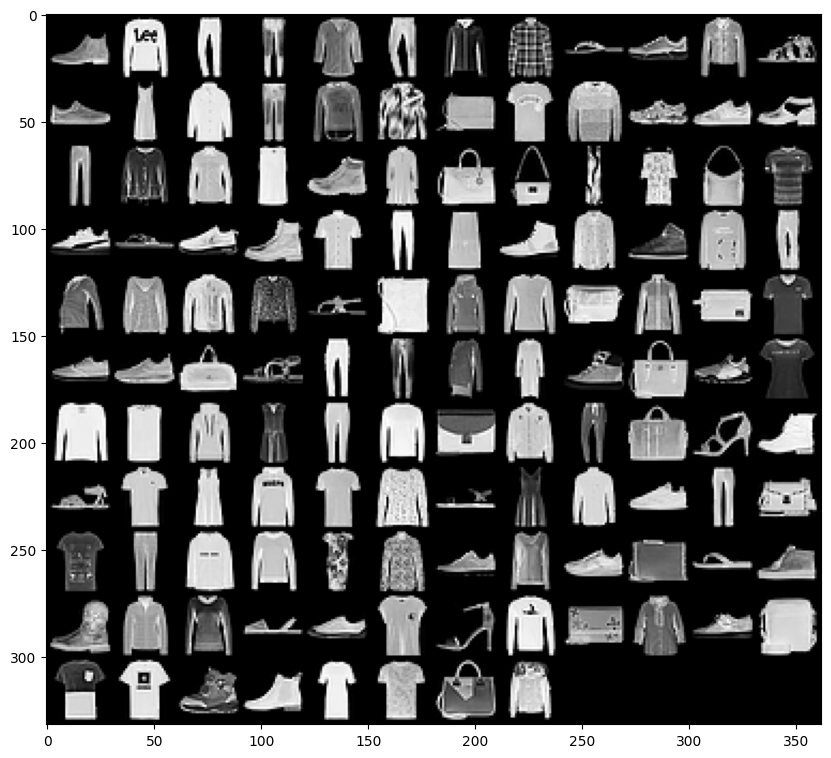

In [26]:
#Show some of the images
imgs, labels = next(iter(dl_train))

res = make_grid(imgs,nrow=12)
res = res.permute(1,2,0)
print(imgs.shape, res.shape)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

In [32]:
print(28*28)

784


In [36]:
# Create the model

class FashionMNIST_CNN(nn.Module):
  def __init__(self, n_layers=1, input_dims=784, input_channels=1):
    super(FashionMNIST_CNN,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_channels,
                  out_channels=16,
                  kernel_size=3,
                  stride=2, padding=1),

        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=3,
                  stride=2, padding=1),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    self.last = nn.Linear(128,10)


  def forward(self,x):

    x = self.conv1(x)
    output = self.last(x)

    return output

#Test this out
model = FashionMNIST_CNN(n_layers=1, input_dims=28*28, input_channels=1)

x = torch.randn(BATCH_SIZE, 1,28,28)
print(x.shape)

out = model(x)
print(out.shape)


torch.Size([128, 1, 28, 28])
torch.Size([128, 10])


In [45]:
# Set the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#Move the model to the device
model.to(device)


In [49]:
# Start the training loop
array_training_loss = []
array_val_loss = []
for epoch in range(EPOCHS):

  running_training_loss = 0

  #Set model in train mode
  model.train()
  for data, labels in dl_train:

    data = data.to(device)
    labels = labels.to(device)

    out = model(data)

    loss = criterion(out,labels)

    # Zero the gradient
    optimizer.zero_grad()

    # calculate the gradients
    loss.backward()

    # Apply the update
    optimizer.step()

    running_training_loss += loss.cpu().item()

  epoch_training_loss = running_training_loss/len(dl_train)

  array_training_loss.append(epoch_training_loss)

  # Get the validation loss

  #Set model in eval mode
  model.eval()

  with torch.no_grad():
    running_val_loss = 0

    for data, labels in dl_val:
      data = data.to(device
      labels = labels.to(device)

      out = model(data)

      loss = criterion(out,labels)
      running_val_loss += loss.cpu().item()

  epoch_val_loss = running_val_loss/len(dl_val)

  array_val_loss.append(epoch_val_loss)



  print(f"EPOCH {epoch}: training_loss = {epoch_training_loss}, val_loss = {epoch_val_loss}")



EPOCH 0: running_loss = 324.6641488969326
EPOCH 1: running_loss = 187.8109957575798


KeyboardInterrupt: 

In [ ]:
# Get training accuracy
#Set model in eval mode
model.eval()

correct_samples = 0.0
total_samples = 0.0

with torch.no_grad():
  for data, labels in dl_test:
    data = data.to(device)
    labels = labels.to(device)

    out = model(data)

    predicted_label = torch.argmax(out,axis=1)

    correct_samples += torch.sum(predicted_label==labels)
    total_samples += data.size[0]


print(f"Accuracy on test set = {correct_samples}/{total_samples}")